# Shots' report of England during the EURO

### Prepare the Data

In [2]:
# Import the required libraries
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.colors import to_rgba
import seaborn as sns
from sklearn import preprocessing

# Get all competitions
competitionsDB = pd.DataFrame(sb.competitions())
# Filter only the 2022 women's euro, id is 53
women_euro = competitionsDB[competitionsDB['competition_id'] == 53]

# Get the England's matches, 53 is competition_id and 106 is season_id
games = sb.matches(53, 106)
england_games = games[(games['home_team'] == "England Women's") | (games['away_team'] == "England Women's")]
assert len(england_games) == 6

england_games_ids = [game[1]['match_id'] for game in england_games.iterrows()]

Let's plot the Goals per 90 vs Expected Goals /90 vs % Shot on target chart for each team in the competition
Let's also plot the shot maps for and against England

In [30]:
# Let's get all the ids of the games
games_ids = [game[1]['match_id'] for game in games.iterrows()]

# Initialize the DF
shots_df = pd.DataFrame(columns=['team', 'goals/90', 'xG/90', 'number_on_target', 'number_off_target'])

for id in games_ids:

    # For each game, get the home_team and the away team
    home_team = str(games[games.match_id == id]['home_team'].values[0])
    away_team = str(games[games.match_id == id]['away_team'].values[0])

    # Get the events of the game and filter only the shots
    events = sb.events(id)
    shots_events = events[events.type == 'Shot']

    # Get the number of minutes of the game
    minute_played = max(events['minute'])

    # Discriminate the shots for home team and away_team
    shots_events_home = shots_events[shots_events.team == home_team]
    shots_events_away = shots_events[shots_events.team == away_team]

    # Divide number of on target shots per number of shots, later
    on_target_home = len(shots_events_home[shots_events_home['shot_outcome'].isin(["Goal", "Post", "Saved", "Saved To Post"])])
    on_target_away = len(shots_events_away[shots_events_away['shot_outcome'].isin(["Goal", "Post", "Saved", "Saved To Post"])])
    number_of_shots_home = len(shots_events_home[shots_events_home['shot_outcome'].isin(['Off T', 'Wayward', 'Saved Off T'])])
    number_of_shots_away = len(shots_events_away[shots_events_away['shot_outcome'].isin(['Off T', 'Wayward', 'Saved Off T'])])

    # Divide number of goals per minutes played
    goals_per_90_home = len(shots_events_home[shots_events_home['shot_outcome'] == "Goal"]) * 90 / minute_played
    goals_per_90_away = len(shots_events_away[shots_events_away['shot_outcome'] == "Goal"]) * 90 / minute_played

    # Divide sum of expected goals values per minutes played
    xg_sum_home = shots_events_home['shot_statsbomb_xg'].sum()
    xg_sum_away = shots_events_away['shot_statsbomb_xg'].sum()
    xg_per_90_home = xg_sum_home * 90 / minute_played
    xg_per_90_away = xg_sum_away * 90 / minute_played

    # Add to Dataframe
    home_series = pd.Series({'team': home_team, 'goals/90':goals_per_90_home,'xG/90': xg_per_90_home, 'number_on_target' : on_target_home, 'number_off_target': number_of_shots_home})
    away_series = pd.Series({'team': away_team, 'goals/90':goals_per_90_away,'xG/90': xg_per_90_away, 'number_on_target' : on_target_away, 'number_off_target': number_of_shots_away})

    shots_df = shots_df.append(home_series, ignore_index=True) ; shots_df = shots_df.append(away_series, ignore_index = True)

# Group by team and compute the mean
shots_df['number_off_target'] = shots_df['number_off_target'].astype(float)
shots_df['number_on_target'] = shots_df['number_on_target'].astype(float)
shots_df = shots_df.groupby(['team']).mean()
# Last thing to do is to get the real percent of on target
percent_on_target = (shots_df['number_on_target'] / (shots_df['number_off_target'] + + shots_df['number_on_target'])) * 100
shots_df['percent_on_target'] = percent_on_target
print(shots_df)

C:\Users\axelg\AppData\Local\Temp\ipykernel_32016\1927103470.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shots_df = shots_df.append(home_series, ignore_index=True) ; shots_df = shots_df.append(away_series, ignore_index = True)
C:\Users\axelg\AppData\Local\Temp\ipykernel_32016\1927103470.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shots_df = shots_df.append(home_series, ignore_index=True) ; shots_df = shots_df.append(away_series, ignore_index = True)
C:\Users\axelg\AppData\Local\Temp\ipykernel_32016\1927103470.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shots_df = shots_df.append(home_series, ignore_index=True) ; shots_df = shots_df.append(away_series, ignore_index = True)
C:\Users\axelg\AppData\Lo

                     goals/90     xG/90  number_on_target  number_off_target  \
team                                                                           
Austria Women's      0.718085  0.875152          5.500000           4.500000   
Belgium Women's      0.708163  0.541778          2.500000           2.500000   
Denmark Women's      0.319149  1.151988          3.333333           5.000000   
England Women's      3.253031  2.562501          7.166667           7.833333   
France Women's       1.642206  2.290158          7.000000           8.400000   
Germany Women's      2.206145  1.890231          5.666667           4.833333   
Iceland Women's      0.938759  1.666336          2.666667           8.000000   
Italy Women's        0.635081  1.106405          5.666667           7.000000   
Netherlands Women's  1.638664  1.094598          4.500000           5.250000   
Northern Ireland     0.315789  0.348371          2.000000           2.000000   
Norway Women's       1.263158  1.240870 

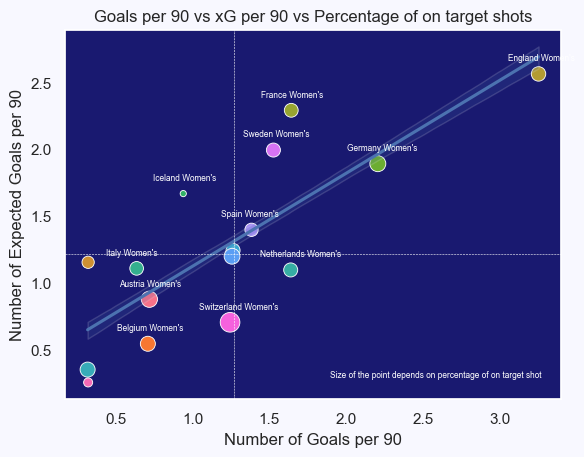

In [41]:
# Plot the chart
ax = sns.scatterplot(data=shots_df, x="goals/90", y="xG/90", hue="team", size="percent_on_target", sizes=(20, 200), legend=False)
ax2 = sns.regplot(data=shots_df, x="goals/90", y="xG/90", scatter=False, ci=30)

# Turns off grid on the left Axis.
ax.grid(False)
ax.annotate('Size of the point depends on percentage of on target shot',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom', color = "white", fontsize=6)

# Change color
sns.set(rc={'axes.facecolor':'midnightblue', 'figure.facecolor':'ghostwhite'})

plt.title('Goals per 90 vs xG per 90 vs Percentage of on target shots')
# Set x-axis label
plt.xlabel('Number of Goals per 90')
# Set y-axis label
plt.ylabel('Number of Expected Goals per 90')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if str(point['val']) in ["England Women's", "Spain Women's", "Germany Women's", "France Women's",
                                 "Belgium Women's", "Iceland Women's", "Italy Women's", "Sweden Women's", "Austria Women's", "Netherlands Women's", "Switzerland Women's"]:
            ax.text(point['x']-0.2, point['y'] + 0.1, str(point['val']), color = 'white', fontsize=6)

shots_df_without_index = shots_df.copy()
shots_df_without_index = shots_df_without_index.reset_index()
label_point(shots_df_without_index['goals/90'], shots_df_without_index['xG/90'], shots_df_without_index['team'], plt.gca())

# Plot the mean for each axis
mean_goals_number = shots_df['goals/90'].mean() ; mean_xg_number = shots_df['xG/90'].mean()

#Drawing a horizontal line at point 1.25
ax.axhline(mean_goals_number, linewidth = 0.4, linestyle="--", color = 'white')
ax.axvline(mean_xg_number, linewidth = 0.4, linestyle="--", color = 'white')

plt.savefig('Shots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Now let's plot the Shot Maps for each games

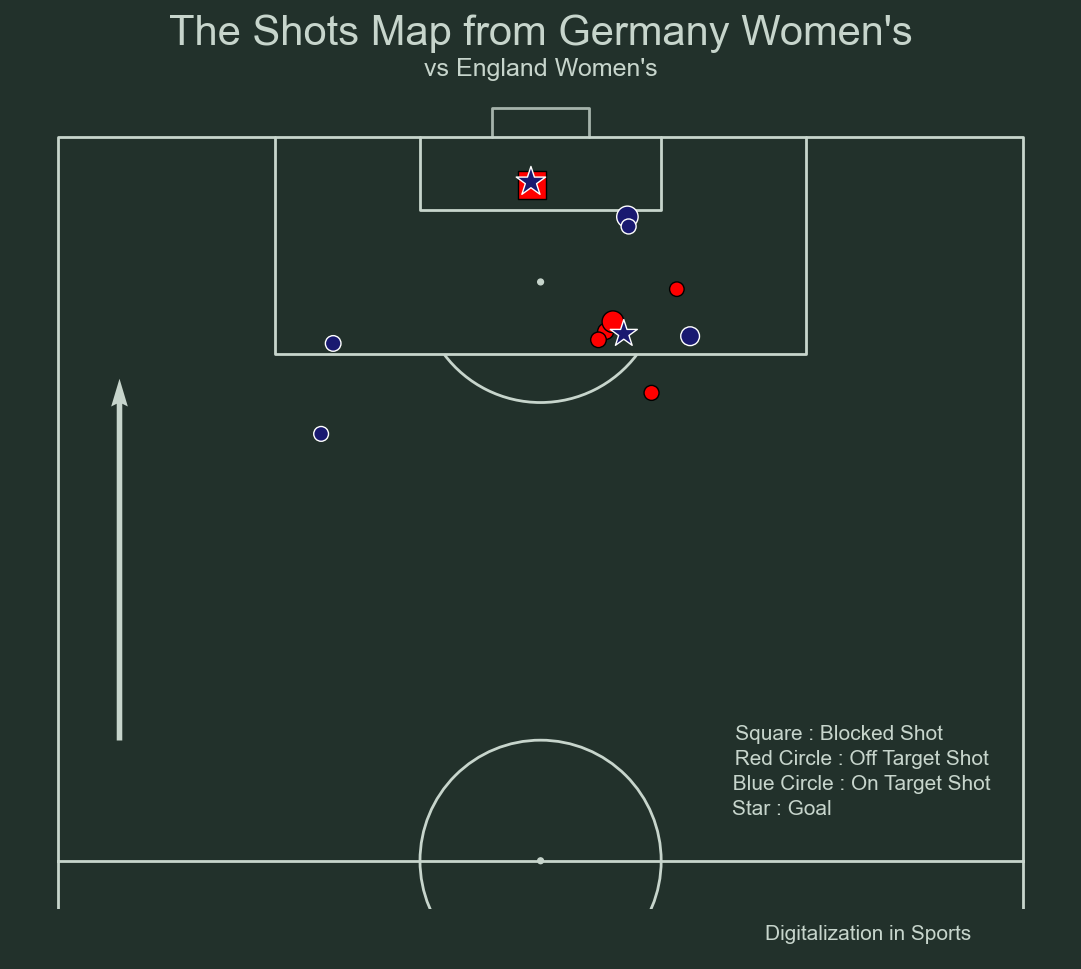

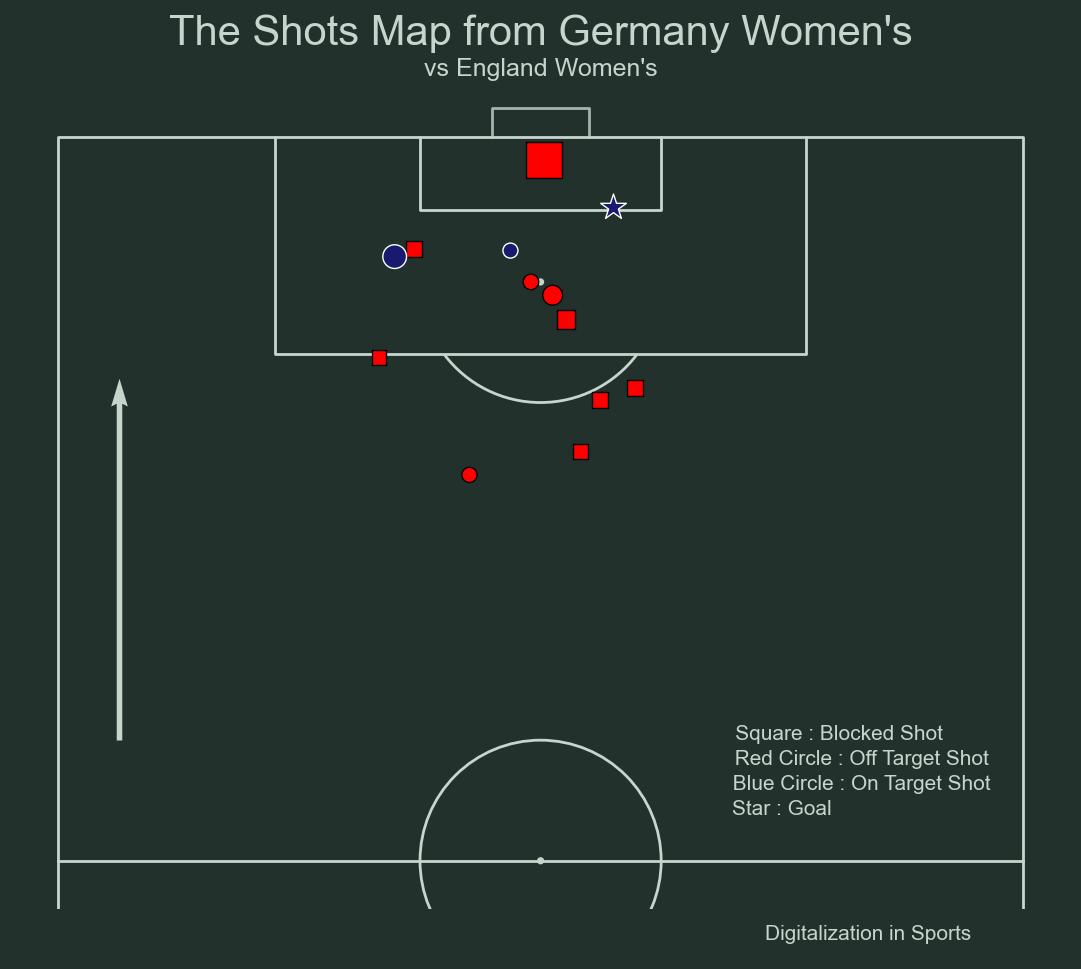

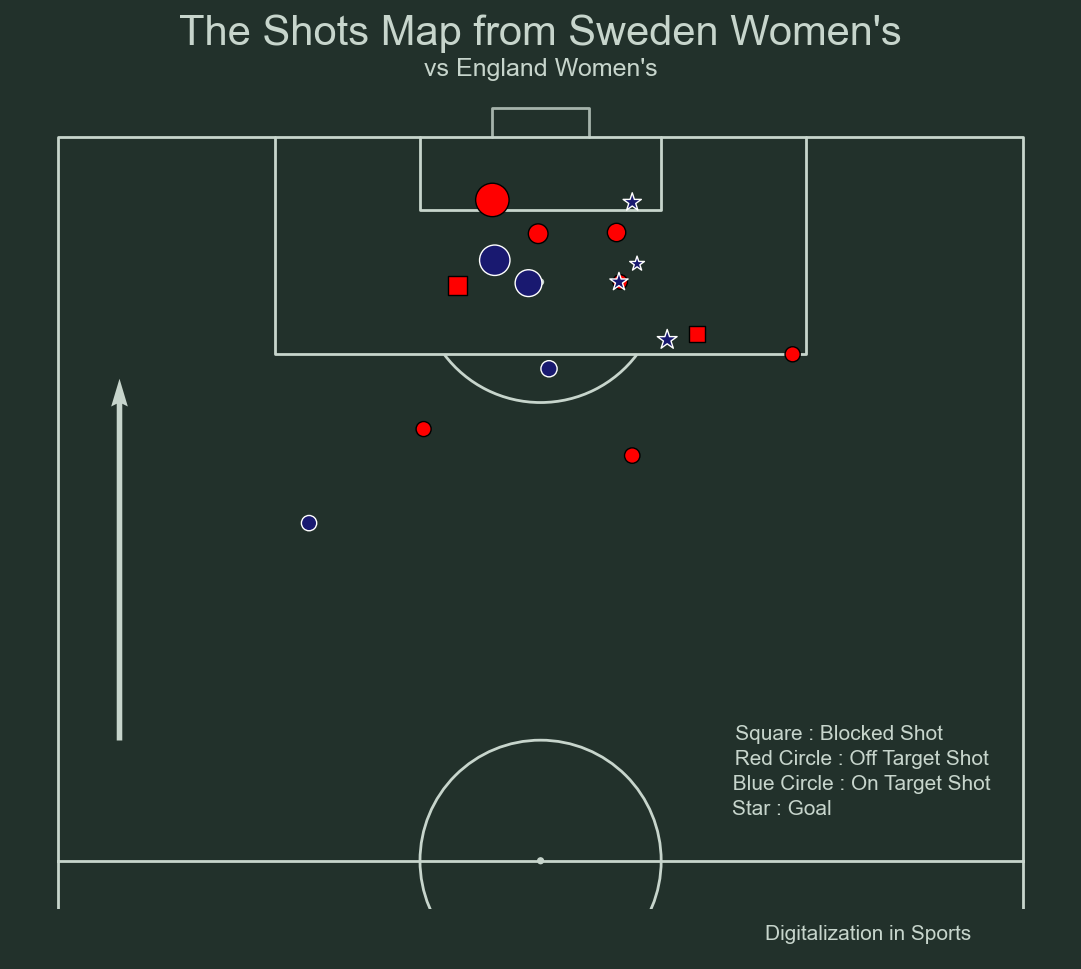

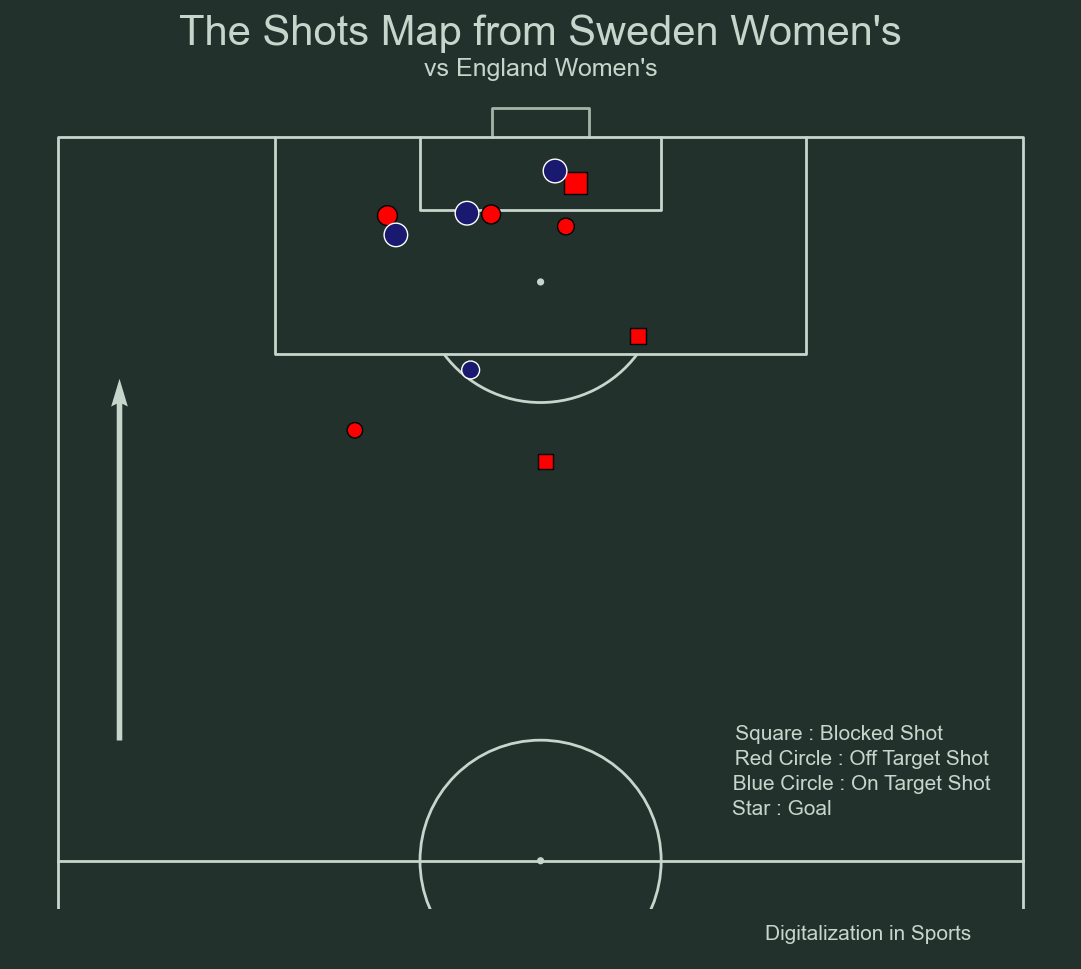

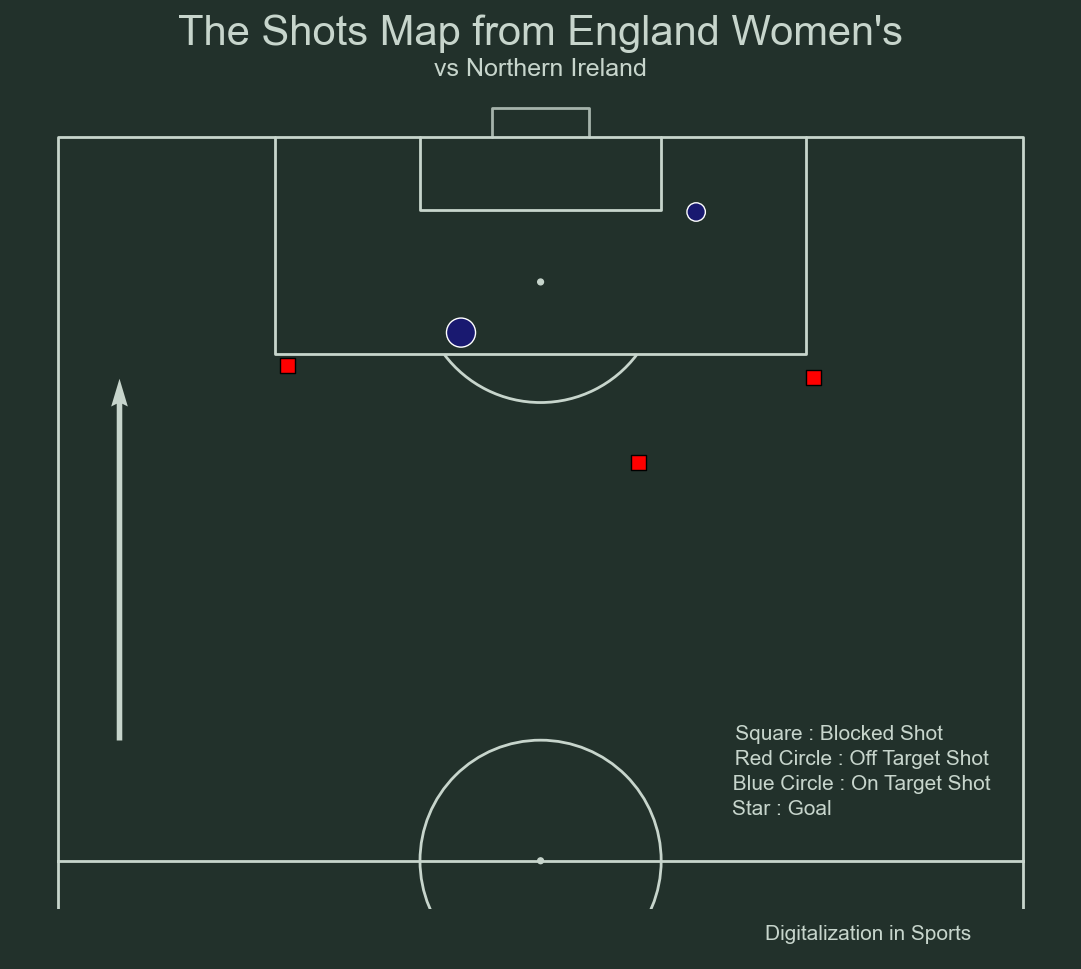

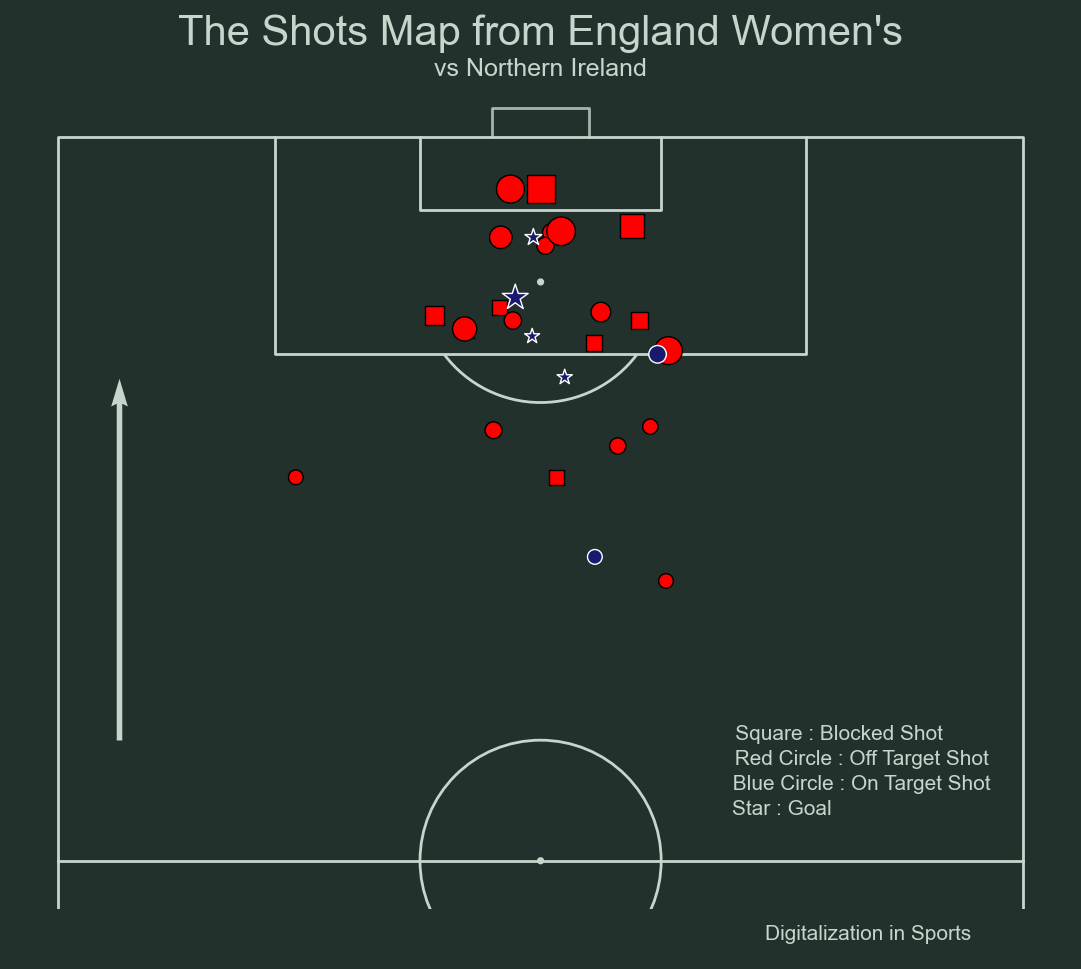

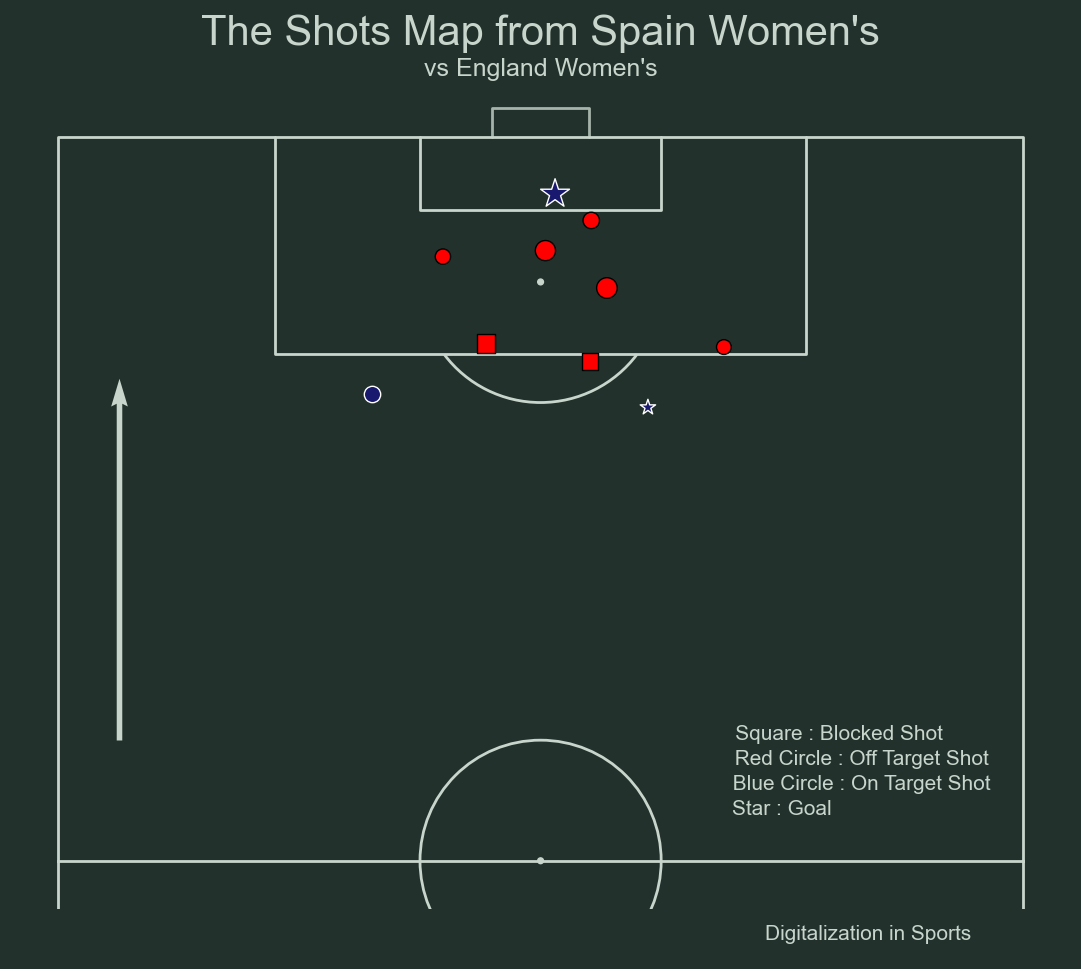

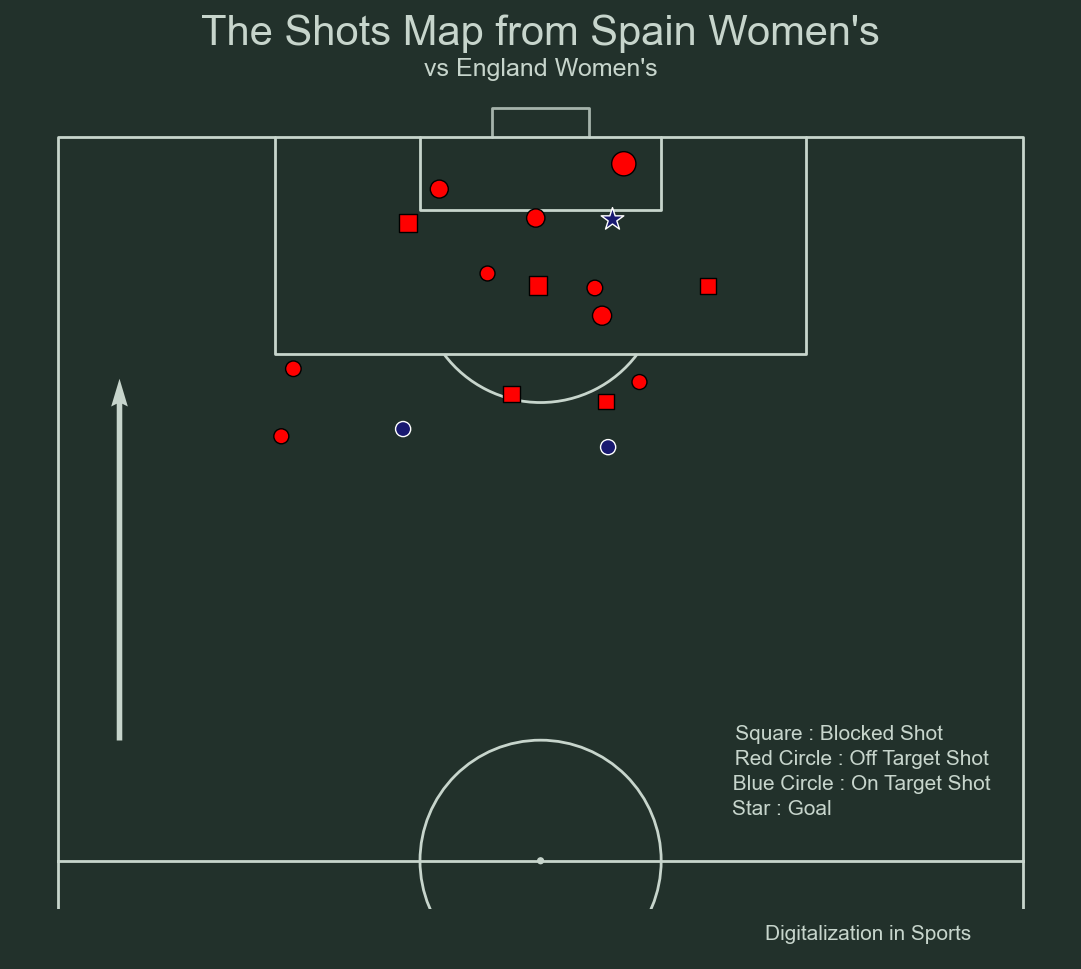

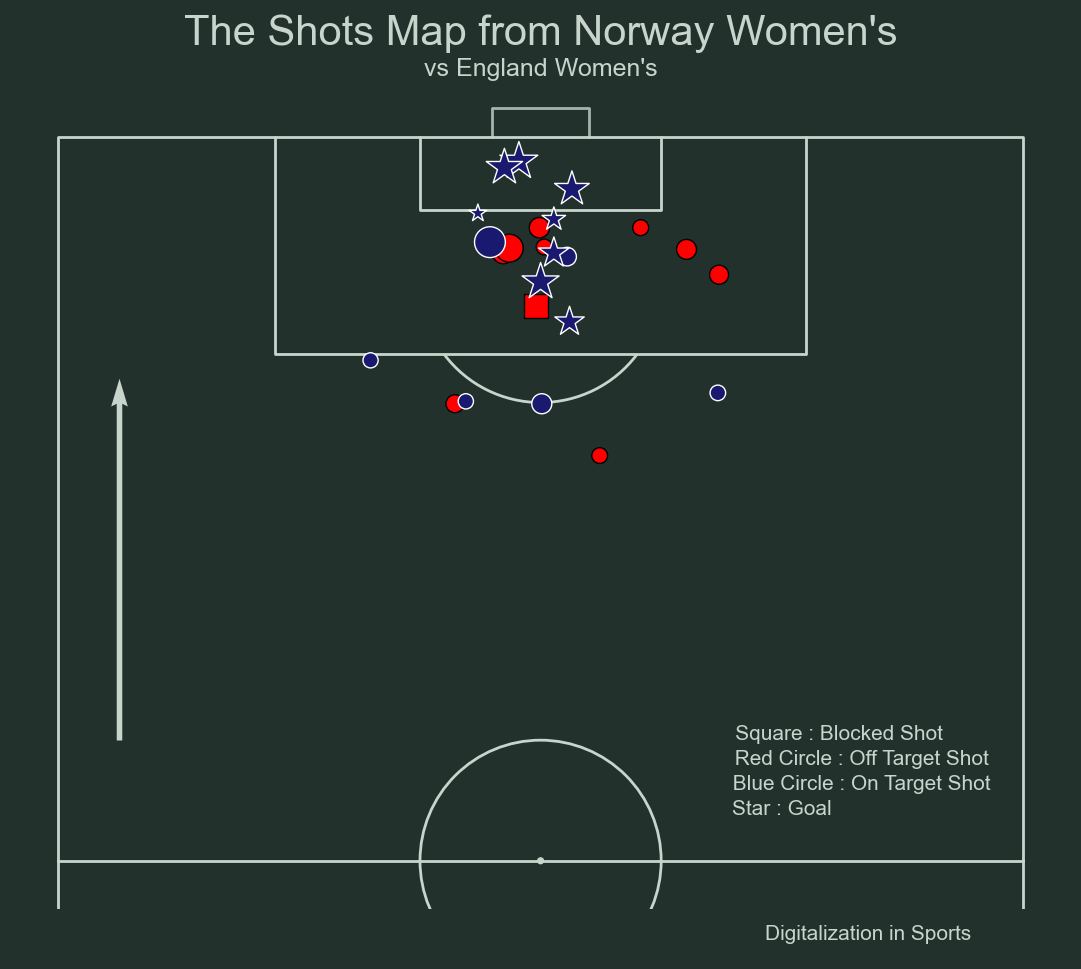

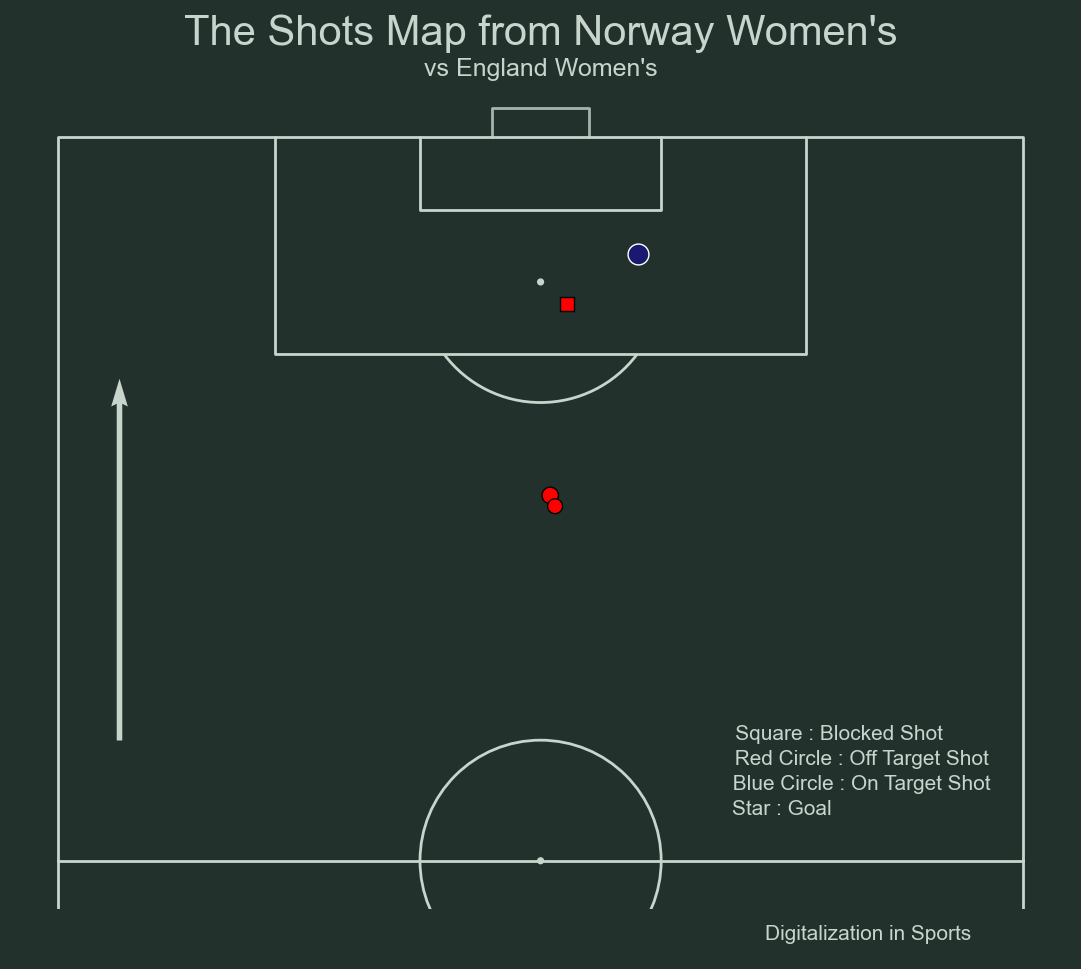

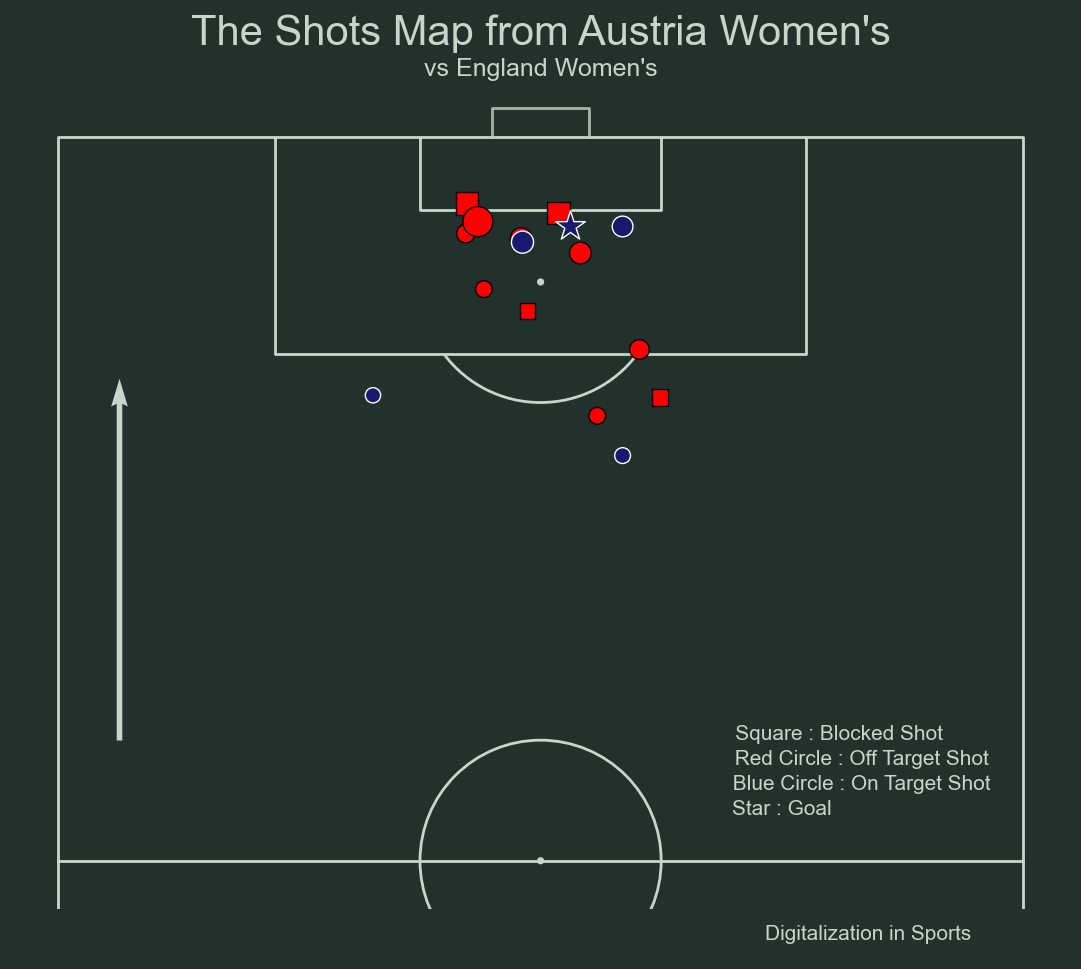

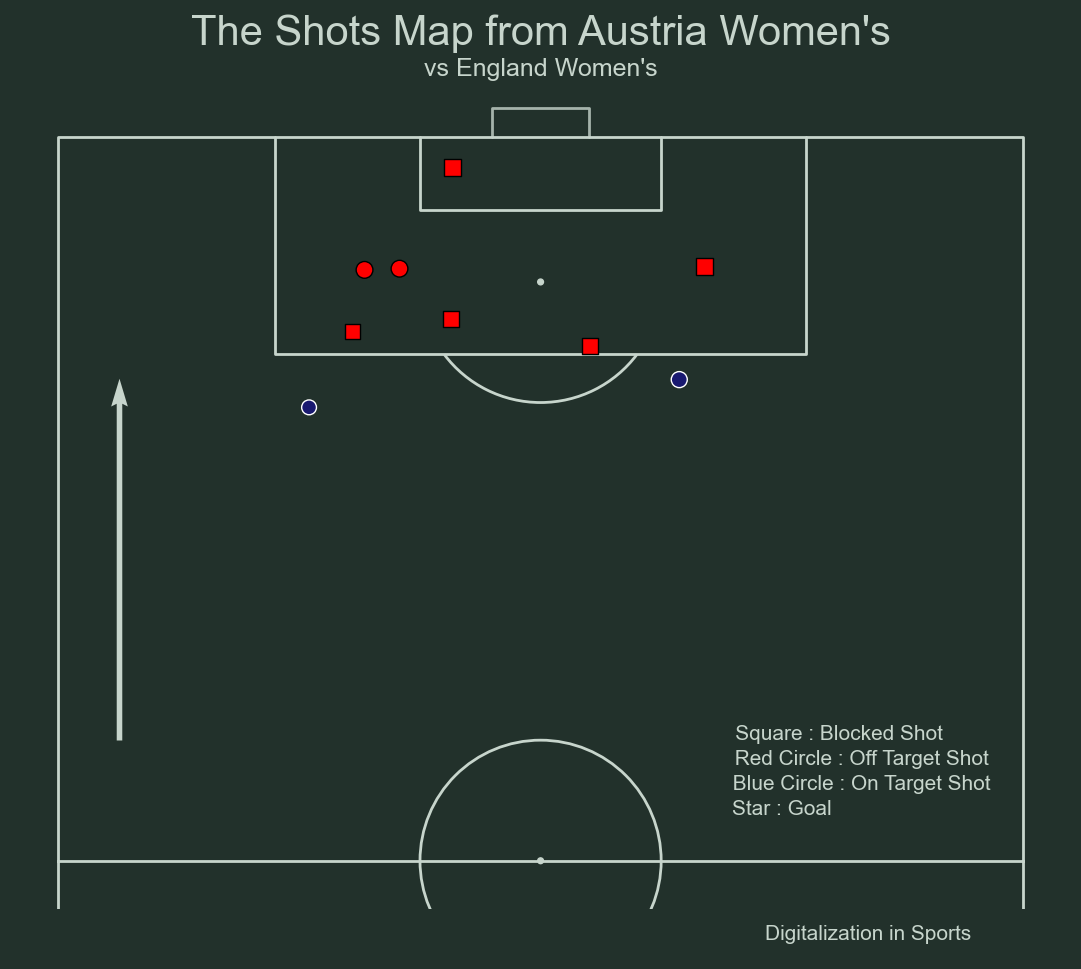

In [73]:
from mplsoccer import VerticalPitch

for id, game in zip(england_games_ids, england_games):

    # For each game, get the home_team and the away team
    home_team = str(games[games.match_id == id]['home_team'].values[0])
    away_team = str(games[games.match_id == id]['away_team'].values[0])

    # Get the events of the game and filter only the shots
    events = sb.events(id)
    shots_events = events[events.type == 'Shot']

    # Get the number of minutes of the game
    minute_played = max(events['minute'])

    # Discriminate the shots for home team and away_team
    shots_events_home = shots_events[shots_events.team == home_team]
    shots_events_away = shots_events[shots_events.team == away_team]

    # Discriminate depending on the outcome
    on_target_home = shots_events_home[shots_events_home['shot_outcome'].isin(["Post", "Saved", "Saved To Post"])]
    on_target_away = shots_events_away[shots_events_away['shot_outcome'].isin(["Post", "Saved", "Saved To Post"])]
    goals_home = shots_events_home[shots_events_home['shot_outcome'] == "Goal"]
    goals_away = shots_events_away[shots_events_away['shot_outcome'] == "Goal"]
    off_target_home = shots_events_home[shots_events_home['shot_outcome'].isin(['Off T', 'Wayward', 'Saved Off T'])]
    off_target_away = shots_events_away[shots_events_away['shot_outcome'].isin(['Off T', 'Wayward', 'Saved Off T'])]
    blocked_home = shots_events_home[shots_events_home['shot_outcome'] == "Blocked"]
    blocked_away = shots_events_away[shots_events_away['shot_outcome'] == "Blocked"]

    pitch = VerticalPitch(pitch_type='statsbomb', half=True, goal_type='box', goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')
    fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False, title_space=0, grid_height=0.82, endnote_height=0.05)
    fig.set_facecolor("#22312b")
    scatter_shots_blocked = pitch.scatter(blocked_home.location.apply(lambda x: x[0]), blocked_home.location.apply(lambda x: x[1]), s=(blocked_home.shot_statsbomb_xg * 900) + 100, c='red', edgecolors='black', marker='s', ax=axs['pitch'])
    scatter_shots_off = pitch.scatter(off_target_home.location.apply(lambda x: x[0]), off_target_home.location.apply(lambda x: x[1]), s=(off_target_home.shot_statsbomb_xg * 900) + 100, c='red', edgecolors='black', marker='o', ax=axs['pitch'])
    scatter_shots_on = pitch.scatter(on_target_home.location.apply(lambda x: x[0]), on_target_home.location.apply(lambda x: x[1]), s=(on_target_home.shot_statsbomb_xg * 900) + 100, c='midnightblue', edgecolors='white', marker='o', ax=axs['pitch'])
    scatter_goals = pitch.scatter(goals_home.location.apply(lambda x: x[0]), goals_home.location.apply(lambda x: x[1]), s=(goals_home.shot_statsbomb_xg * 900) + 100, c='midnightblue', edgecolors='white', marker='*', ax=axs['pitch'])
    pitch.arrows(70, 5, 100, 5, ax=axs['pitch'], color='#c7d5cc')
    axs['endnote'].text(0.84, 0.5, 'Digitalization in Sports', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['endnote'].text(0.80, 4.5, '   Square : Blocked Shot', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['endnote'].text(0.83, 4.0, ' Red Circle : Off Target Shot', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['endnote'].text(0.83, 3.5, ' Blue Circle : On Target Shot', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['endnote'].text(0.75, 3.0, 'Star : Goal', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['title'].text(0.5, 0.7, 'The Shots Map from ' + away_team, color='#c7d5cc', va='center', ha='center', fontsize=30)
    axs['title'].text(0.5, 0.25, 'vs ' + home_team, color='#c7d5cc', va='center', ha='center', fontsize=18)
    plt.savefig('Shot_map_' + home_team +'_vs_' + away_team+'.png', dpi=300, bbox_inches='tight')
    plt.show()

    pitch = VerticalPitch(pitch_type='statsbomb', half=True, goal_type='box', goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')
    fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0, axis=False, title_space=0, grid_height=0.82, endnote_height=0.05)
    fig.set_facecolor("#22312b")
    scatter_shots_blocked = pitch.scatter(blocked_away.location.apply(lambda x: x[0]), blocked_away.location.apply(lambda x: x[1]), s=(blocked_away.shot_statsbomb_xg * 900) + 100, c='red', edgecolors='black', marker='s', ax=axs['pitch'])
    scatter_shots_off = pitch.scatter(off_target_away.location.apply(lambda x: x[0]), off_target_away.location.apply(lambda x: x[1]), s=(off_target_away.shot_statsbomb_xg * 900) + 100, c='red', edgecolors='black', marker='o', ax=axs['pitch'])
    scatter_shots_on = pitch.scatter(on_target_away.location.apply(lambda x: x[0]), on_target_away.location.apply(lambda x: x[1]), s=(on_target_away.shot_statsbomb_xg * 900) + 100, c='midnightblue', edgecolors='white', marker='o', ax=axs['pitch'])
    scatter_goals = pitch.scatter(goals_away.location.apply(lambda x: x[0]), goals_away.location.apply(lambda x: x[1]), s=(goals_away.shot_statsbomb_xg * 900) + 100, c='midnightblue', edgecolors='white', marker='*', ax=axs['pitch'])
    pitch.arrows(70, 5, 100, 5, ax=axs['pitch'], color='#c7d5cc')
    axs['endnote'].text(0.84, 0.5, 'Digitalization in Sports', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['endnote'].text(0.80, 4.5, '   Square : Blocked Shot', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['endnote'].text(0.83, 4.0, ' Red Circle : Off Target Shot', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['endnote'].text(0.83, 3.5, ' Blue Circle : On Target Shot', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['endnote'].text(0.75, 3.0, 'Star : Goal', color='#c7d5cc', va='center', ha='center', fontsize=15)
    axs['title'].text(0.5, 0.7, 'The Shots Map from ' + away_team, color='#c7d5cc', va='center', ha='center', fontsize=30)
    axs['title'].text(0.5, 0.25, 'vs ' + home_team, color='#c7d5cc', va='center', ha='center', fontsize=18)
    plt.savefig('Shot_map_' + away_team +'_vs_' + home_team+'.png', dpi=300, bbox_inches='tight')
    plt.show()